# Covid prediction Random Forest Confirmed Cases

### Loading libraries

In [2]:
import pandas as pd
import pandas as pd 
import random

In [3]:
import math
import time
import datetime
import operator 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-dark')
#print(plt.style.available)
%matplotlib inline

from sklearn import metrics

In [6]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

In [7]:
import warnings
warnings.filterwarnings("ignore")

### Preparation for predictions

#### Data Loading

In [8]:
#dataset
covid_df= pd.read_csv("corona_pred_china-2.csv")
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,01/22/2020,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,"6355,7","5,24",28800.0
1,01/22/2020,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,"337,4",0,28200.0
2,01/22/2020,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,"16183,0","4,86",19400.0
3,01/22/2020,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,"496,0",0,17800.0
4,01/22/2020,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,"640,3",0,23400.0


#### Data transformations

In [9]:
#Converting "Observation Date" into Datetime format
covid_df["ObservationDate"]=pd.to_datetime(covid_df["ObservationDate"])
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             10022 non-null  datetime64[ns]
 1   Country                     10022 non-null  object        
 2   Continent                   10022 non-null  object        
 3   Confirmed                   10022 non-null  float64       
 4   Deaths                      10022 non-null  float64       
 5   Recovered                   10022 non-null  float64       
 6   Active Cases                10022 non-null  float64       
 7   Population                  10022 non-null  float64       
 8   Area (sq. mi.)              10022 non-null  float64       
 9   Pop. Density (per sq. mi.)  10022 non-null  object        
 10  Net migration               10022 non-null  object        
 11  GDP ($ per capita)          10022 non-null  float64   

In [10]:
# Changing datatype of Population density and Net Migration columns as float
cols=["Pop. Density (per sq. mi.)","Net migration"]                             
for i in cols:
    covid_df[i]=covid_df[i].str.replace(",","").astype(float)
covid_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             10022 non-null  datetime64[ns]
 1   Country                     10022 non-null  object        
 2   Continent                   10022 non-null  object        
 3   Confirmed                   10022 non-null  float64       
 4   Deaths                      10022 non-null  float64       
 5   Recovered                   10022 non-null  float64       
 6   Active Cases                10022 non-null  float64       
 7   Population                  10022 non-null  float64       
 8   Area (sq. mi.)              10022 non-null  float64       
 9   Pop. Density (per sq. mi.)  10022 non-null  float64       
 10  Net migration               10022 non-null  float64       
 11  GDP ($ per capita)          10022 non-null  float64   

In [11]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,63557.0,524.0,28800.0
1,2020-01-22,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,3374.0,0.0,28200.0
2,2020-01-22,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,161830.0,486.0,19400.0
3,2020-01-22,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,4960.0,0.0,17800.0
4,2020-01-22,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,6403.0,0.0,23400.0


In [12]:
# Sorting based on the country names
covid_df = covid_df.sort_values(["Country", "ObservationDate"]).reset_index(drop=True)

In [13]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             10022 non-null  datetime64[ns]
 1   Country                     10022 non-null  object        
 2   Continent                   10022 non-null  object        
 3   Confirmed                   10022 non-null  float64       
 4   Deaths                      10022 non-null  float64       
 5   Recovered                   10022 non-null  float64       
 6   Active Cases                10022 non-null  float64       
 7   Population                  10022 non-null  float64       
 8   Area (sq. mi.)              10022 non-null  float64       
 9   Pop. Density (per sq. mi.)  10022 non-null  float64       
 10  Net migration               10022 non-null  float64       
 11  GDP ($ per capita)          10022 non-null  float64   

In [14]:
covid_df.shape

(10022, 12)

In [15]:
# Calculating days since the first occurance for each country
covid_df['days_since_first']=0
covid_df['previous_Confirmed'] = 0
#covid_df['increase_rate'] = 0
previous_Confirmed=0
confirm_difference=0

for i in covid_df.index[1:]:
    if covid_df['Country'][i]==covid_df['Country'][i-1]:
        covid_df.loc[i,'days_since_first']=(covid_df.at[i-1,'days_since_first']+1)
        previous_Confirmed=covid_df.at[i-1,'Confirmed']
        confirm_difference= covid_df.at[i,'Confirmed']-previous_Confirmed
        covid_df.loc[i,'previous_Confirmed']=previous_Confirmed        
#        if ((previous_Confirmed!=0) & (confirm_difference>0) ):
#            covid_df.loc[i,'increase_rate']=((confirm_difference/previous_Confirmed))       
#        else:
#            covid_df.loc[i,'increase_rate']=0
    else:
        covid_df.loc[i,'days_since_first'] = 0
        covid_df.loc[i,'previous_Confirmed'] = 0
#        covid_df.loc[i,'increase_rate'] = 0  

In [16]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita),days_since_first,previous_Confirmed
0,2020-02-24,Afghanistan,Asia,1.0,0.0,0.0,1.0,31056997.0,647500.0,480.0,2306.0,700.0,0,0.0
1,2020-02-25,Afghanistan,Asia,1.0,0.0,0.0,1.0,31056997.0,647500.0,480.0,2306.0,700.0,1,1.0
2,2020-02-26,Afghanistan,Asia,1.0,0.0,0.0,1.0,31056997.0,647500.0,480.0,2306.0,700.0,2,1.0
3,2020-02-27,Afghanistan,Asia,1.0,0.0,0.0,1.0,31056997.0,647500.0,480.0,2306.0,700.0,3,1.0
4,2020-02-28,Afghanistan,Asia,1.0,0.0,0.0,1.0,31056997.0,647500.0,480.0,2306.0,700.0,4,1.0


In [20]:
# Ensuring that previous confirmed column type is int
covid_df['previous_Confirmed'].astype(int)
#covid_df=covid_df[covid_df['increase_rate']>=0]

0          0
1          1
2          1
3          1
4          1
        ... 
10017    712
10018      9
10019    712
10020      9
10021    712
Name: previous_Confirmed, Length: 10022, dtype: int32

In [21]:
covid_df.set_index('Country',inplace=True)

#### Check for highest number of confirmed cases in Europe

In [22]:
covid_df[covid_df['Continent'] == "Europe"].groupby('Country').agg(
                {
                     'Confirmed':max,    # Sum duration per group
                     'days_since_first': max,  # get the max of days
                }).sort_values(["Confirmed", "days_since_first"]).tail()

,Confirmed,days_since_first
Country,,
United Kingdom,149569.0,85
Germany,156513.0,88
France,161644.0,92
Italy,195351.0,85
Spain,223759.0,84


In [23]:
covid_df.columns

Index(['ObservationDate', 'Continent', 'Confirmed', 'Deaths', 'Recovered',
       'Active Cases', 'Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Net migration', 'GDP ($ per capita)',
       'days_since_first', 'previous_Confirmed'],
      dtype='object')

In [24]:
covid_df.to_csv("COVID_For_Orange.csv")

### Random Forest Regressor

In [25]:
X=covid_df.copy()
del X['Continent']
del X['ObservationDate']
del X['Deaths']
del X['Recovered']
del X['Active Cases']
del X['GDP ($ per capita)']
#del X['Population']
#del X['Area (sq. mi.)']
#del X['Pop. Density (per sq. mi.)']
#del X['Net migration']



In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10022 entries, Afghanistan to not found
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Confirmed                   10022 non-null  float64
 1   Population                  10022 non-null  float64
 2   Area (sq. mi.)              10022 non-null  float64
 3   Pop. Density (per sq. mi.)  10022 non-null  float64
 4   Net migration               10022 non-null  float64
 5   days_since_first            10022 non-null  int64  
 6   previous_Confirmed          10022 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 626.4+ KB


In [27]:
X["Net migration"].fillna(0, inplace=True)
X["Pop. Density (per sq. mi.)"].fillna(0, inplace=True)

In [28]:
X.isnull().any()

Confirmed                     False
Population                    False
Area (sq. mi.)                False
Pop. Density (per sq. mi.)    False
Net migration                 False
days_since_first              False
previous_Confirmed            False
dtype: bool

In [29]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Confirmed,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Confirmed,1.00,0.13,0.19,-0.03,0.05,0.29,1.00
Population,0.13,1.00,0.32,-0.05,-0.01,0.13,0.13
Area (sq. mi.),0.19,0.32,1.00,-0.08,0.09,0.13,0.18
Pop. Density (per sq. mi.),-0.03,-0.05,-0.08,1.00,0.26,0.11,-0.03
Net migration,0.05,-0.01,0.09,0.26,1.00,0.14,0.05
days_since_first,0.29,0.13,0.13,0.11,0.14,1.00,0.29
previous_Confirmed,1.00,0.13,0.18,-0.03,0.05,0.29,1.00


In [30]:
# Pick only features that are correlated more than 0.2
y=X[['Confirmed']].copy()  
y.head()  

,Confirmed
Country,
Afghanistan,1.0
Afghanistan,1.0
Afghanistan,1.0
Afghanistan,1.0
Afghanistan,1.0


In [31]:
print(X.shape)
X.head()

(10022, 7)


,Confirmed,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Country,,,,,,,
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,0,0.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,1,1.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,2,1.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,3,1.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,4,1.0


In [32]:
# To get rid of +e format
pd.options.display.float_format = '{:20,.0f}'.format

#### Train Test Split

In [33]:
X.drop(['Confirmed'], axis=1, inplace=True)
X.reset_index(drop=True)

X_train = X.iloc[0:0,:].copy()
X_test = X.iloc[0:0,:].copy() 
X_val = X.iloc[0:0,:].copy()
y_train = y.iloc[0:0,:].copy()
y_test = y.iloc[0:0,:].copy()
y_val = y.iloc[0:0,:].copy()
for country in covid_df.index.unique()[0:]:
    country_df = covid_df[covid_df.index == country] 
    filter = (country_df.days_since_first >= country_df.days_since_first.max()-3) & (country_df.days_since_first < country_df.days_since_first.max()-1)
    X_train = X_train.append(country_df[country_df.days_since_first < country_df.days_since_first.max()-3][['Population','Area (sq. mi.)','Pop. Density (per sq. mi.)','Net migration','days_since_first','previous_Confirmed']])
    X_val = X_val.append(country_df[filter])[['Population','Area (sq. mi.)','Pop. Density (per sq. mi.)','Net migration','days_since_first','previous_Confirmed']]
    X_test = X_test.append(country_df[country_df.days_since_first >= country_df.days_since_first.max()-1][['Population','Area (sq. mi.)','Pop. Density (per sq. mi.)','Net migration','days_since_first','previous_Confirmed']])    

    y_train = y_train.append(country_df[country_df.days_since_first < country_df.days_since_first.max()-3])[['Confirmed']]
    y_val = y_val.append(country_df[filter])[['Confirmed']]    
    y_test = y_test.append(country_df[country_df.days_since_first >= country_df.days_since_first.max()-1][['Confirmed']])

In [80]:
 
X_test[X_test.index == "Italy"]

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Country,,,,,,
Italy,"58,133,509","301,230","1,930",207,84,"189,973"
Italy,"58,133,509","301,230","1,930",207,85,"192,994"


In [35]:
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
# print(f"X_validate shape is {X_validate.shape}")
print(f"y_train is {y_train.shape}")
# print(f"y_validate shape is {y_validate.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (9219, 6)
X_test shape is (404, 6)
y_train is (9219, 1)
y_test shape is (404, 1)


## Random Forest

#### Defining the model and checking the best score

In [36]:
#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID

regressor = RandomForestRegressor()
parameters = {"criterion": ['mse'], 
              "n_estimators":[10, 100, 400], 
              "min_samples_leaf": [0.1, 1, 5, 10, 20, 50], 
              "random_state" : [1]
            #  "max_features": "auto"
            # "oob_score ": TRUE
             }

In [37]:
#DEFINE YOUR GRIDSEARCH 
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train.to_numpy(),y_train.to_numpy())

In [38]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']


***GRIDSEARCH RESULTS***
Best score: 0.854576 using {'criterion': 'mse', 'min_samples_leaf': 1, 'n_estimators': 400, 'random_state': 1}


In [39]:
columns = np.asarray(X.columns)
#columns = np.asarray([columns])
from sklearn import tree
r = tree.export_text(gs.best_estimator_.estimators_[0],feature_names=columns.tolist(), max_depth=3)
print(r)

|--- previous_Confirmed <= 259592.50
|   |--- previous_Confirmed <= 57767.50
|   |   |--- previous_Confirmed <= 13950.50
|   |   |   |--- previous_Confirmed <= 3577.00
|   |   |   |   |--- truncated branch of depth 36
|   |   |   |--- previous_Confirmed >  3577.00
|   |   |   |   |--- truncated branch of depth 17
|   |   |--- previous_Confirmed >  13950.50
|   |   |   |--- previous_Confirmed <= 33972.00
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- previous_Confirmed >  33972.00
|   |   |   |   |--- truncated branch of depth 9
|   |--- previous_Confirmed >  57767.50
|   |   |--- previous_Confirmed <= 118481.00
|   |   |   |--- previous_Confirmed <= 84149.50
|   |   |   |   |--- truncated branch of depth 10
|   |   |   |--- previous_Confirmed >  84149.50
|   |   |   |   |--- truncated branch of depth 8
|   |   |--- previous_Confirmed >  118481.00
|   |   |   |--- previous_Confirmed <= 160673.50
|   |   |   |   |--- truncated branch of depth 9
|   |   |   |--- previo

In [40]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

####  Training the model

In [41]:
#we establish the model with the best estimator according to Gridsearch results
gs = gs.best_estimator_ 

gs = gs.fit(X_train.to_numpy(),y_train.to_numpy())

In [42]:
#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test.to_numpy(), y_test.to_numpy())

0.9835149921883828

#### Testing the model

In [43]:
y_pred = gs.predict(X_test.to_numpy())

In [45]:
pred_df = pd.DataFrame({'Actual':y_test['Confirmed'], 'Pred':y_pred}) 
pred_df

,Actual,Pred
Country,,
Afghanistan,"1,351","1,475"
Afghanistan,"1,463","1,478"
Albania,678,684
Albania,712,694
Algeria,"3,127","3,302"
...,...,...
Zambia,84,97
Zimbabwe,29,31
Zimbabwe,31,32


#### Evaluation results

In [46]:
print("explained_variance_score: ",explained_variance_score(y_test, y_pred))

explained_variance_score:  0.9835403223780614


In [47]:
print("MAE train: ", metrics.mean_absolute_error(y_train.to_numpy(), gs.predict(X_train.to_numpy()))) 
print("MSE train: ",metrics.mean_squared_error(y_train.to_numpy(), gs.predict(X_train.to_numpy())))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train.to_numpy(), gs.predict(X_train.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_train.to_numpy(), gs.predict(X_train.to_numpy()))))

print("MAE test: ", metrics.mean_absolute_error(y_test.to_numpy(), gs.predict(X_test.to_numpy()))) 
print("MSE test: ",metrics.mean_squared_error(y_test.to_numpy(), gs.predict(X_test.to_numpy())))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test.to_numpy(), gs.predict(X_test.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_test.to_numpy(), gs.predict(X_test.to_numpy()))))

MAE train:  49.492801943294516
MSE train:  146165.00424848273
RMSE train:  382.31532044698747
r2:  0.9999215830469456
MAE test:  997.1308605257504
MSE test:  82436529.67864618
RMSE test:  9079.456463833403
r2:  0.9917232437471569


## Random Forest Regression -  For different countries

In [48]:
import plotly.io as pio

In [49]:
plt.style.use('dark_background')

### Using Kaggle dataset to cross check the results of future prediction 

In [50]:
covid_df_kaggle= pd.read_csv("covid_19_data_Kaggle.csv")

In [51]:
covid_df_kaggle["ObservationDate"]=pd.to_datetime(covid_df_kaggle["ObservationDate"])

In [52]:
covid_df_kaggle.shape

(20574, 8)

### Random Forest Regression - France

In [58]:
covid_df_kaggle_France = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "France"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [59]:
covid_df_kaggle_France_plt = covid_df_kaggle_France[covid_df_kaggle_France['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [60]:
filter_condn = (covid_df_kaggle_France['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_France['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_France = covid_df_kaggle_France[filter_condn].reset_index(drop=True)
covid_df_kaggle_France

X_France_df = X[X.index == "France"].copy()
X_France_test = X_France_df.head().copy()
X_France_test=X_France_test.reset_index(drop=True)
X_France_test['days_since_first'] = X_France_test['previous_Confirmed'] =  0
X_France_test.loc[0,'days_since_first'] =  X_France_df["days_since_first"].iloc[-1]+1
#X_France_test.loc[0,'increase_rate']=X_France_df["increase_rate"].iloc[-1]+1
X_France_test.loc[0,'previous_Confirmed'] = y[y.index == "France"].max()[0]

#X_France_test['increase_rate']=X_France_df["increase_rate"].max()


for i in range(0,5):
    X_France_test.loc[i,'days_since_first'] = X_France_test.loc[0,'days_since_first'] + i

X_France_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_France_test.iloc[i].to_numpy()]))
    X_France_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_France_test['predicted_infections']= pred.iloc[:, 0] 

X_France_test["ObservationDate"] = covid_df_kaggle_France["ObservationDate"]
covid_df_kaggle_France_plt["predicted_infections"] = covid_df_kaggle_France_plt["Confirmed"] 

covid_df_kaggle_France_plt.iloc[-5,4] = X_France_test.loc[0,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-4,4] = X_France_test.loc[1,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-3,4] = X_France_test.loc[2,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-2,4] = X_France_test.loc[3,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-1,4] = X_France_test.loc[4,'predicted_infections']
    

X_France_test=X_France_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_France_test["Actual infections"] = covid_df_kaggle_France["Confirmed"]
X_France_test["Date"] = covid_df_kaggle_France["ObservationDate"]
X_France_test = X_France_test.iloc[0:5]
X_France_test 

,predicted_infections,Actual infections,Date
0,"169,490","162,220",2020-04-26
1,"173,631","165,963",2020-04-27
2,"178,264","169,053",2020-04-28
3,"183,713","166,543",2020-04-29
4,"191,633","167,299",2020-04-30


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text major ticklabel objects>)

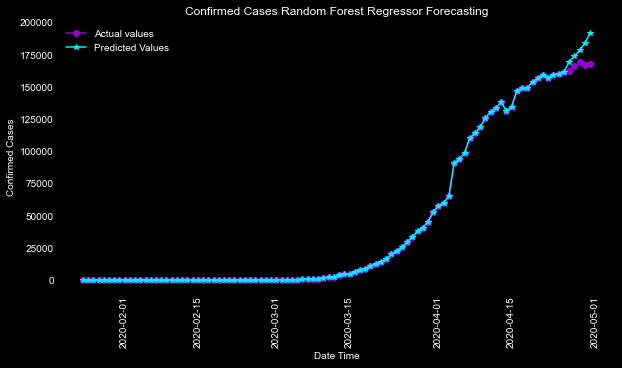

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_France_plt["ObservationDate"],covid_df_kaggle_France_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_France_plt["ObservationDate"],covid_df_kaggle_France_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Spain

In [74]:
covid_df_kaggle_Spain = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Spain"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [75]:
covid_df_kaggle_Spain_plt = covid_df_kaggle_Spain[covid_df_kaggle_Spain['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [76]:
filter_condn = (covid_df_kaggle_Spain['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Spain['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Spain = covid_df_kaggle_Spain[filter_condn].reset_index(drop=True)
covid_df_kaggle_Spain

X_Spain_df = X[X.index == "Spain"].copy()
X_Spain_test = X_Spain_df.head().copy()
X_Spain_test=X_Spain_test.reset_index(drop=True)
X_Spain_test['days_since_first'] = X_Spain_test['previous_Confirmed'] =  0
X_Spain_test.loc[0,'days_since_first'] =  X_Spain_df["days_since_first"].iloc[-1]+1
#X_Spain_test.loc[0,'increase_rate']=X_Spain_df["increase_rate"].iloc[-1]+1
X_Spain_test.loc[0,'previous_Confirmed'] = y[y.index == "Spain"].max()[0]

#X_Spain_test['increase_rate']=X_Spain_df["increase_rate"].max()


for i in range(0,5):
    X_Spain_test.loc[i,'days_since_first'] = X_Spain_test.loc[0,'days_since_first'] + i

X_Spain_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Spain_test.iloc[i].to_numpy()]))
    X_Spain_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Spain_test['predicted_infections']= pred.iloc[:, 0] 

X_Spain_test["ObservationDate"] = covid_df_kaggle_Spain["ObservationDate"]
covid_df_kaggle_Spain_plt["predicted_infections"] = covid_df_kaggle_Spain_plt["Confirmed"] 

covid_df_kaggle_Spain_plt.iloc[-5,4] = X_Spain_test.loc[0,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-4,4] = X_Spain_test.loc[1,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-3,4] = X_Spain_test.loc[2,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-2,4] = X_Spain_test.loc[3,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-1,4] = X_Spain_test.loc[4,'predicted_infections']
    

X_Spain_test=X_Spain_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Spain_test["Actual infections"] = covid_df_kaggle_Spain["Confirmed"]
X_Spain_test["Date"] = covid_df_kaggle_Spain["ObservationDate"]
X_Spain_test = X_Spain_test.iloc[0:5]
X_Spain_test 

,predicted_infections,Actual infections,Date
0,"268,699","226,629",2020-04-26
1,"442,879","229,422",2020-04-27
2,"581,703","232,128",2020-04-28
3,"682,578","236,899",2020-04-29
4,"742,185","213,435",2020-04-30


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text major ticklabel objects>)

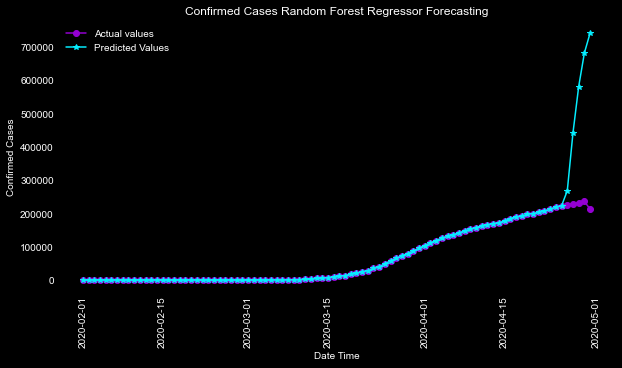

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Spain_plt["ObservationDate"],covid_df_kaggle_Spain_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Spain_plt["ObservationDate"],covid_df_kaggle_Spain_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Germany

In [70]:
covid_df_kaggle_Germany = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Germany"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [71]:
covid_df_kaggle_Germany_plt = covid_df_kaggle_Germany[covid_df_kaggle_Germany['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [72]:
filter_condn = (covid_df_kaggle_Germany['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Germany['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Germany = covid_df_kaggle_Germany[filter_condn].reset_index(drop=True)
covid_df_kaggle_Germany

X_Germany_df = X[X.index == "Germany"].copy()
X_Germany_test = X_Germany_df.head().copy()
X_Germany_test=X_Germany_test.reset_index(drop=True)
X_Germany_test['days_since_first'] = X_Germany_test['previous_Confirmed'] =  0
X_Germany_test.loc[0,'days_since_first'] =  X_Germany_df["days_since_first"].iloc[-1]+1
#X_Germany_test.loc[0,'increase_rate']=X_Germany_df["increase_rate"].iloc[-1]+1
X_Germany_test.loc[0,'previous_Confirmed'] = y[y.index == "Germany"].max()[0]

#X_Germany_test['increase_rate']=X_Germany_df["increase_rate"].max()


for i in range(0,5):
    X_Germany_test.loc[i,'days_since_first'] = X_Germany_test.loc[0,'days_since_first'] + i

X_Germany_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Germany_test.iloc[i].to_numpy()]))
    X_Germany_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Germany_test['predicted_infections']= pred.iloc[:, 0] 

X_Germany_test["ObservationDate"] = covid_df_kaggle_Germany["ObservationDate"]
covid_df_kaggle_Germany_plt["predicted_infections"] = covid_df_kaggle_Germany_plt["Confirmed"] 

covid_df_kaggle_Germany_plt.iloc[-5,4] = X_Germany_test.loc[0,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-4,4] = X_Germany_test.loc[1,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-3,4] = X_Germany_test.loc[2,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-2,4] = X_Germany_test.loc[3,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-1,4] = X_Germany_test.loc[4,'predicted_infections']
    

X_Germany_test=X_Germany_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Germany_test["Actual infections"] = covid_df_kaggle_Germany["Confirmed"]
X_Germany_test["Date"] = covid_df_kaggle_Germany["ObservationDate"]
X_Germany_test = X_Germany_test.iloc[0:5]
X_Germany_test 

,predicted_infections,Actual infections,Date
0,"158,889","157,770",2020-04-26
1,"162,221","158,758",2020-04-27
2,"168,330","159,912",2020-04-28
3,"172,880","161,539",2020-04-29
4,"177,857","163,009",2020-04-30


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text major ticklabel objects>)

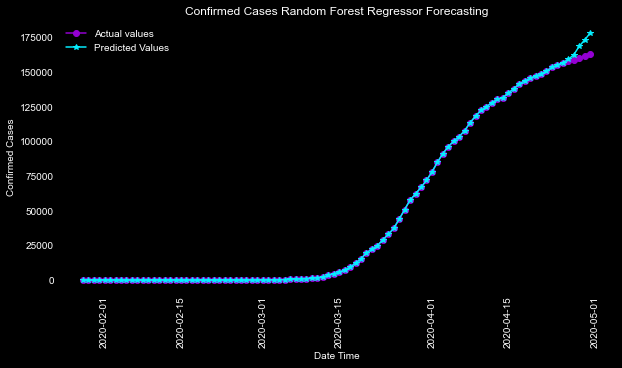

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Switzerland

In [66]:
covid_df_kaggle_Switzerland = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Switzerland"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [67]:
covid_df_kaggle_Switzerland_plt = covid_df_kaggle_Switzerland[covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [68]:
filter_condn = (covid_df_kaggle_Switzerland['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Switzerland = covid_df_kaggle_Switzerland[filter_condn].reset_index(drop=True)
covid_df_kaggle_Switzerland

X_Switzerland_df = X[X.index == "Switzerland"].copy()
X_Switzerland_test = X_Switzerland_df.head().copy()
X_Switzerland_test=X_Switzerland_test.reset_index(drop=True)
X_Switzerland_test['days_since_first'] = X_Switzerland_test['previous_Confirmed'] =  0
X_Switzerland_test.loc[0,'days_since_first'] =  X_Switzerland_df["days_since_first"].iloc[-1]+1
#X_Switzerland_test.loc[0,'increase_rate']=X_Switzerland_df["increase_rate"].iloc[-1]+1
X_Switzerland_test.loc[0,'previous_Confirmed'] = y[y.index == "Switzerland"].max()[0]

#X_Switzerland_test['increase_rate']=X_Switzerland_df["increase_rate"].max()


for i in range(0,5):
    X_Switzerland_test.loc[i,'days_since_first'] = X_Switzerland_test.loc[0,'days_since_first'] + i

X_Switzerland_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Switzerland_test.iloc[i].to_numpy()]))
    X_Switzerland_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Switzerland_test['predicted_infections']= pred.iloc[:, 0] 

X_Switzerland_test["ObservationDate"] = covid_df_kaggle_Switzerland["ObservationDate"]
covid_df_kaggle_Switzerland_plt["predicted_infections"] = covid_df_kaggle_Switzerland_plt["Confirmed"] 

covid_df_kaggle_Switzerland_plt.iloc[-5,4] = X_Switzerland_test.loc[0,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-4,4] = X_Switzerland_test.loc[1,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-3,4] = X_Switzerland_test.loc[2,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-2,4] = X_Switzerland_test.loc[3,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-1,4] = X_Switzerland_test.loc[4,'predicted_infections']
    

X_Switzerland_test=X_Switzerland_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Switzerland_test["Actual infections"] = covid_df_kaggle_Switzerland["Confirmed"]
X_Switzerland_test["Date"] = covid_df_kaggle_Switzerland["ObservationDate"]
X_Switzerland_test = X_Switzerland_test.iloc[0:5]
X_Switzerland_test 

,predicted_infections,Actual infections,Date
0,"31,372","29,061",2020-04-26
1,"33,610","29,164",2020-04-27
2,"35,341","29,264",2020-04-28
3,"38,217","29,407",2020-04-29
4,"40,463","29,586",2020-04-30


(array([737485., 737499., 737516., 737530., 737546.]),
 <a list of 5 Text major ticklabel objects>)

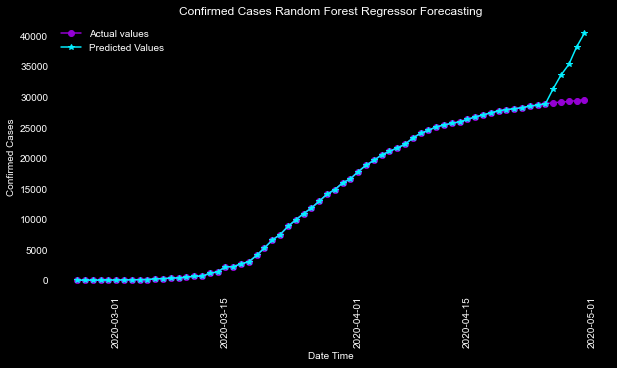

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Switzerland_plt["ObservationDate"],covid_df_kaggle_Switzerland_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Switzerland_plt["ObservationDate"],covid_df_kaggle_Switzerland_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Italy

In [62]:
covid_df_kaggle_Italy = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Italy"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [63]:
covid_df_kaggle_Italy_plt = covid_df_kaggle_Italy[covid_df_kaggle_Italy['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [64]:
filter_condn = (covid_df_kaggle_Italy['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Italy['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Italy = covid_df_kaggle_Italy[filter_condn].reset_index(drop=True)
covid_df_kaggle_Italy

X_Italy_df = X[X.index == "Italy"].copy()
X_Italy_test = X_Italy_df.head().copy()
X_Italy_test=X_Italy_test.reset_index(drop=True)
X_Italy_test['days_since_first'] = X_Italy_test['previous_Confirmed'] =  0
X_Italy_test.loc[0,'days_since_first'] =  X_Italy_df["days_since_first"].iloc[-1]+1
#X_Italy_test.loc[0,'increase_rate']=X_Italy_df["increase_rate"].iloc[-1]+1
X_Italy_test.loc[0,'previous_Confirmed'] = y[y.index == "Italy"].max()[0]

#X_Italy_test['increase_rate']=X_Italy_df["increase_rate"].max()


for i in range(0,5):
    X_Italy_test.loc[i,'days_since_first'] = X_Italy_test.loc[0,'days_since_first'] + i

X_Italy_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Italy_test.iloc[i].to_numpy()]))
    X_Italy_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Italy_test['predicted_infections']= pred.iloc[:, 0] 

X_Italy_test["ObservationDate"] = covid_df_kaggle_Italy["ObservationDate"]
covid_df_kaggle_Italy_plt["predicted_infections"] = covid_df_kaggle_Italy_plt["Confirmed"] 

covid_df_kaggle_Italy_plt.iloc[-5,4] = X_Italy_test.loc[0,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-4,4] = X_Italy_test.loc[1,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-3,4] = X_Italy_test.loc[2,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-2,4] = X_Italy_test.loc[3,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-1,4] = X_Italy_test.loc[4,'predicted_infections']
    

X_Italy_test=X_Italy_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Italy_test["Actual infections"] = covid_df_kaggle_Italy["Confirmed"]
X_Italy_test["Date"] = covid_df_kaggle_Italy["ObservationDate"]
X_Italy_test = X_Italy_test.iloc[0:5]
X_Italy_test 

,predicted_infections,Actual infections,Date
0,"200,397","197,675",2020-04-26
1,"201,930","199,414",2020-04-27
2,"202,235","201,505",2020-04-28
3,"203,063","203,591",2020-04-29
4,"205,292","205,463",2020-04-30


(array([737456., 737470., 737485., 737499., 737516., 737530., 737546.]),
 <a list of 7 Text major ticklabel objects>)

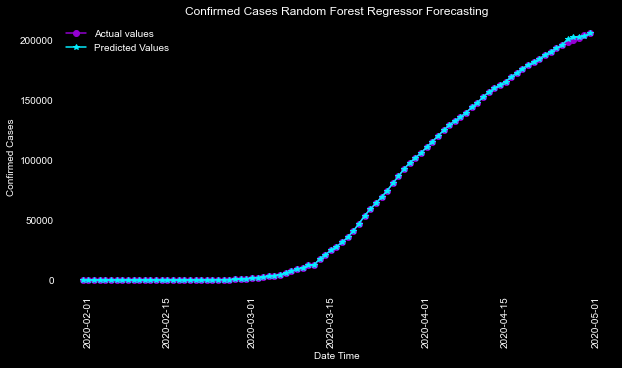

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Italy_plt["ObservationDate"],covid_df_kaggle_Italy_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Italy_plt["ObservationDate"],covid_df_kaggle_Italy_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)